In [1]:
# @title Running in Colab

from IPython.display import HTML, Javascript, display

display(
    HTML(
        """<a href="https://colab.research.google.com/github/evan-lloyd/mechinterp-experiments/blob/main/tiny_stories_sae/e2e_demo.ipynb" target="_blank" id="colab-button">
            Run this notebook in Google Colab
        </a>"""
    )
)
display(
    Javascript("""
        setTimeout(() => {
            if(typeof google.colab != "undefined") {
                document.querySelector("#colab-button").remove()
            }
        }, 0);
        """)
)

<IPython.core.display.Javascript object>

# Initialize notebook environment


In [2]:
import os

# If we're running in Colab, we need to clone the non-notebook source from git.
if os.getenv("COLAB_RELEASE_TAG") and not os.path.isdir(
    "/content/mechinterp-experiments"
):
    ip = get_ipython()  #  pyright: ignore[reportUndefinedVariable]
    ip.run_cell_magic(
        "bash",
        "",
        """
    git clone --filter=blob:none --no-checkout https://github.com/evan-lloyd/mechinterp-experiments.git
    cd mechinterp-experiments
    git sparse-checkout init --no-cone
    echo "/tiny_stories_sae" > .git/info/sparse-checkout
    git checkout
  """,
    )
    ip.run_line_magic("cd", "mechinterp-experiments/tiny_stories_sae")
else:
    print("Already cloned source, or not running in Colab.")

# Nice for dev, but not needed for Colab.
try:
    # This uses a library called jurigged to hot-reload code when it is changed.
    # For reasons I've never been able to figure out, the IPython %autoreload magic
    # completely fails to work with the kind of structure I use in this notebook.
    import tiny_stories_sae._autoreload
except Exception:
    pass

Already cloned source, or not running in Colab.


In [3]:
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer

# Tweak TRAINING_BATCH_SIZE for your hardware if necessary
if torch.cuda.is_available():
    TRAINING_DEVICE = "cuda"
    TRAINING_BATCH_SIZE = 16
    E2E_BATCH_SIZE = 4
elif torch.mps.is_available():
    TRAINING_DEVICE = "mps"
    TRAINING_BATCH_SIZE = 8
    E2E_BATCH_SIZE = 2
else:
    TRAINING_DEVICE = "cpu"
    TRAINING_BATCH_SIZE = 8
    E2E_BATCH_SIZE = 2

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
training_dataset = load_dataset("roneneldan/TinyStories", split="train", streaming=True)
validation_dataset = load_dataset(
    "roneneldan/TinyStories", split="validation", streaming=True
)
model = AutoModelForCausalLM.from_pretrained("roneneldan/TinyStories-33M").to(
    TRAINING_DEVICE
)

print(model)

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/968 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/291M [00:00<?, ?B/s]

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-3): 4 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_feat

model.safetensors:   0%|          | 0.00/291M [00:00<?, ?B/s]

In [ ]:
# Caches model activations to these directories; modify if necessary, or set to None to disable.
# These take up ~16GB and ~1.5GB respectively, but will save a fair bit of time when running
# the notebook, since they can be re-used across all methods we're comparing.
TRAINING_CACHE_DIR = None
VALIDATION_CACHE_DIR = None
# TRAINING_CACHE_DIR = ".training_cache"
# VALIDATION_CACHE_DIR = ".validation_cache"
NUM_TRAINING_TOKENS = int(1e7)
EVAL_INTERVAL = int(1e4)
NUM_VALIDATION_TOKENS = int(1e6)
D_MODEL = model.config.hidden_size
D_SAE = D_MODEL * 4
TOKENIZER_BATCH_SIZE = 128

# Train SAEs for comparison


In [5]:
from tiny_stories_sae.sae import SAE
from tiny_stories_sae.training import TrainingConfig, TrainingMethod, train

saes = {
    method: {
        layer: SAE(
            D_MODEL,
            D_SAE,
            device=model.device,
            kind="topk",
            topk=100,
        )
        for layer in range(model.config.num_layers)
    }
    for method in TrainingMethod
    # We will clone these from the corresponding pre-fine-tuned method to save time
    if method not in (TrainingMethod.finetuned, TrainingMethod.next_layer_finetuned)
}


def linear_decay(frac_trained: float):
    return 1.0 - frac_trained


training_config = {
    method: TrainingConfig(
        tokenizer_batch_size=TOKENIZER_BATCH_SIZE,
        training_batch_size=TRAINING_BATCH_SIZE,
        e2e_batch_size=E2E_BATCH_SIZE,
        num_train_tokens=NUM_TRAINING_TOKENS,
        eval_interval=EVAL_INTERVAL,
        train_layers=list(range(model.config.num_layers)),
        lr=1e-3,
        finetune_lr_schedule=linear_decay,  # per Karvonen (2025)
        use_downstream_saes=method
        in (TrainingMethod.next_layer, TrainingMethod.next_layer_finetuned),
        downstream_reconstruction_weight=1.0
        if method in (TrainingMethod.next_layer, TrainingMethod.next_layer_finetuned)
        else 0.0,
        reconstruction_weight=1.0,
        balance_reconstruction_losses=method
        in (TrainingMethod.next_layer, TrainingMethod.next_layer_finetuned),
        method=method,
        finetune_fraction=0.10
        if method in (TrainingMethod.finetuned, TrainingMethod.next_layer_finetuned)
        else None,
    )
    for method in TrainingMethod
}

training_results = {}

In [ ]:
import os

from tiny_stories_sae.training import build_cache

if TRAINING_CACHE_DIR and (
    not os.path.exists(TRAINING_CACHE_DIR) or not os.listdir(TRAINING_CACHE_DIR)
):
    build_cache(
        TRAINING_CACHE_DIR,
        model,
        tokenizer,
        training_dataset,
        tokenizer_batch_size=TOKENIZER_BATCH_SIZE,
        inference_batch_size=TRAINING_BATCH_SIZE,
        num_tokens=NUM_TRAINING_TOKENS,
    )

if VALIDATION_CACHE_DIR and (
    not os.path.exists(VALIDATION_CACHE_DIR) or not os.listdir(VALIDATION_CACHE_DIR)
):
    build_cache(
        VALIDATION_CACHE_DIR,
        model,
        tokenizer,
        validation_dataset,
        tokenizer_batch_size=TOKENIZER_BATCH_SIZE,
        inference_batch_size=TRAINING_BATCH_SIZE,
        num_tokens=NUM_VALIDATION_TOKENS,
    )

# Standard loss (current layer reconstruction error only)

In [7]:
from tiny_stories_sae.ops import clone_sae


# Save some time by initializing KL-fine-tuning SAEs when we hit the initial training threshold
def _maybe_clone_to_finetuned(layer: int, num_tokens: int):
    if TrainingMethod.finetuned not in saes:
        saes[TrainingMethod.finetuned] = {}

    if (
        layer in saes[TrainingMethod.finetuned]
        or num_tokens
        < (1.0 - training_config[TrainingMethod.finetuned].finetune_fraction)
        * training_config[TrainingMethod.finetuned].num_train_tokens
    ):
        return
    saes[TrainingMethod.finetuned][layer] = clone_sae(saes[TrainingMethod.standard][layer])


training_results[TrainingMethod.standard] = train(
    model,
    tokenizer,
    saes[TrainingMethod.standard],
    training_dataset,
    training_config[TrainingMethod.standard],
    cache_dir=TRAINING_CACHE_DIR,
    reinit_weights=True,
    post_step_hook=_maybe_clone_to_finetuned,
)

Layer 3

  0%|          | 0/10000000 [00:00<?, ?it/s]

Layer 2

  0%|          | 0/10000000 [00:00<?, ?it/s]

Layer 1

  0%|          | 0/10000000 [00:00<?, ?it/s]

Layer 0

  0%|          | 0/10000000 [00:00<?, ?it/s]

## Next-layer auxiliary loss (my method)


In [8]:
def _maybe_clone_to_next_layer_finetuned(layer: int, num_tokens: int):
    if TrainingMethod.next_layer_finetuned not in saes:
        saes[TrainingMethod.next_layer_finetuned] = {}

    if (
        layer in saes[TrainingMethod.next_layer_finetuned]
        or num_tokens
        < (1.0 - training_config[TrainingMethod.next_layer_finetuned].finetune_fraction)
        * training_config[TrainingMethod.next_layer_finetuned].num_train_tokens
    ):
        return
    saes[TrainingMethod.next_layer_finetuned][layer] = clone_sae(saes[TrainingMethod.next_layer][layer])


training_results[TrainingMethod.next_layer] = train(
    model,
    tokenizer,
    saes[TrainingMethod.next_layer],
    training_dataset,
    training_config[TrainingMethod.next_layer],
    cache_dir=TRAINING_CACHE_DIR,
    reinit_weights=True,
    post_step_hook=_maybe_clone_to_next_layer_finetuned,
)

Layer 3

  0%|          | 0/10000000 [00:00<?, ?it/s]

Layer 2

  0%|          | 0/10000000 [00:00<?, ?it/s]

Layer 1

  0%|          | 0/10000000 [00:00<?, ?it/s]

Layer 0

  0%|          | 0/10000000 [00:00<?, ?it/s]

# Next-layer with KL finetune

In [9]:
from tiny_stories_sae.ops import splice_training_trajectory

training_results[TrainingMethod.next_layer_finetuned] = train(
    model,
    tokenizer,
    saes[TrainingMethod.next_layer_finetuned],
    training_dataset,
    training_config[TrainingMethod.next_layer_finetuned],
    cache_dir=TRAINING_CACHE_DIR,
    reinit_weights=False,
    start_at_finetune=True,
)

# Since we cloned the pre-fine-tuning model, it has the same training trajectory up until
# finetuning starts.
training_results[TrainingMethod.next_layer_finetuned] = splice_training_trajectory(
    training_results[TrainingMethod.next_layer],
    training_results[TrainingMethod.next_layer_finetuned],
)

Layer 3

  0%|          | 0/1000000 [00:00<?, ?it/s]

Layer 2

  0%|          | 0/1000000 [00:00<?, ?it/s]

Layer 1

  0%|          | 0/1000000 [00:00<?, ?it/s]

Layer 0

  0%|          | 0/1000000 [00:00<?, ?it/s]

## End-to-end training

Recreation of the method SAE_e2e+ds from

> Braun, Dan, Jordan Taylor, Nicholas Goldowsky-Dill, and Lee Sharkey. 2024. “Identifying Functionally Important Features with End-to-End Sparse Dictionary Learning.” arXiv [Cs.LG]. arXiv. http://arxiv.org/abs/2405.12241.


In [10]:
training_results[TrainingMethod.e2e] = train(
    model,
    tokenizer,
    saes[TrainingMethod.e2e],
    training_dataset,
    training_config[TrainingMethod.e2e],
    cache_dir=TRAINING_CACHE_DIR,
    reinit_weights=True,
)

Layer 3

  0%|          | 0/10000000 [00:00<?, ?it/s]

Layer 2

  0%|          | 0/10000000 [00:00<?, ?it/s]

Layer 1

  0%|          | 0/10000000 [00:00<?, ?it/s]

Layer 0

  0%|          | 0/10000000 [00:00<?, ?it/s]

## KL fine-tuning

Recreation of the KL fine-tuning method from

> Karvonen, Adam. 2025. “Revisiting End-to-End Sparse Autoencoder Training: A Short Finetune Is All You Need.” arXiv [Cs.LG]. arXiv. http://arxiv.org/abs/2503.17272.


In [11]:
training_results[TrainingMethod.finetuned] = train(
    model,
    tokenizer,
    saes[TrainingMethod.finetuned],
    training_dataset,
    training_config[TrainingMethod.finetuned],
    cache_dir=TRAINING_CACHE_DIR,
    reinit_weights=False,
    start_at_finetune=True,
)

training_results[TrainingMethod.finetuned] = splice_training_trajectory(
    training_results[TrainingMethod.standard],
    training_results[TrainingMethod.finetuned],
)

Layer 3

  0%|          | 0/1000000 [00:00<?, ?it/s]

Layer 2

  0%|          | 0/1000000 [00:00<?, ?it/s]

Layer 1

  0%|          | 0/1000000 [00:00<?, ?it/s]

Layer 0

  0%|          | 0/1000000 [00:00<?, ?it/s]

# Evaluations and comparisons


## Train-time evaluations

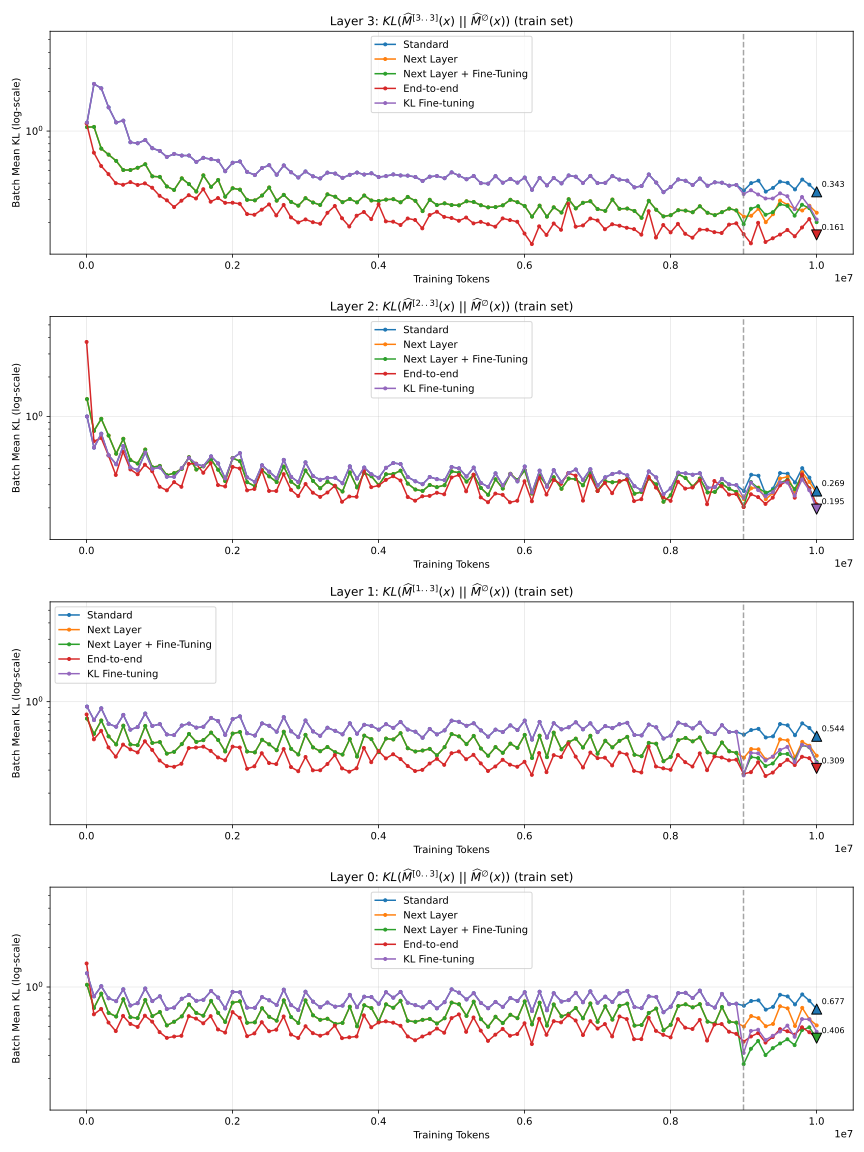

In [12]:
from tiny_stories_sae.ops import current_plot_to_svg
import matplotlib.pyplot as plt

fig, axes = plt.subplots(
    model.config.num_layers, 1, figsize=(12, 4 * model.config.num_layers)
)

# Collect all KL values to determine consistent y-axis limits
all_kl_values = []
for layer in range(model.config.num_layers):
    for method in training_results:
        data = training_results[method][layer]["rep_kl"]
        if data:
            _, kl_values = zip(*data)
            all_kl_values.extend(kl_values)

# Calculate y-axis limits
if all_kl_values:
    y_min, y_max = min(all_kl_values), max(all_kl_values)
else:
    y_min, y_max = 1e-3, 1e0  # Default range if no data

for i, layer in enumerate(range(model.config.num_layers - 1, -1, -1)):
    ax = axes[i]

    # Collect final values for each method to find min/max
    final_values = {}
    line_colors = {}
    for method in training_results:
        data = training_results[method][layer]["rep_kl"]
        if data:
            tokens, kl_values = zip(*data)
            # Skip plotting some steps to reduce clutter
            tokens = tokens[::10]
            kl_values = kl_values[::10]
            line = ax.plot(tokens, kl_values, label=method.value, marker="o", markersize=3)
            line_colors[method] = line[0].get_color()
            
            if tokens and kl_values:
                final_values[method] = (tokens[-1], kl_values[-1])

    # Find methods with highest and lowest final values
    if final_values:
        min_method = min(final_values.keys(), key=lambda m: final_values[m][1])
        max_method = max(final_values.keys(), key=lambda m: final_values[m][1])
        
        # Add indicators for min (down triangle) and max (up triangle)
        for method in [min_method, max_method]:
            final_token, final_kl = final_values[method]
            marker = '^' if method == max_method else 'v'
            ax.scatter(final_token, final_kl, s=100, marker=marker, 
                      color=line_colors[method], edgecolors='black', linewidth=1, zorder=10)
            ax.annotate(f'{final_kl:.3}', 
                       xy=(final_token, final_kl),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=8, ha='left')

    # Add vertical line at finetuning start
    ax.axvline(x=9e6, color='gray', linestyle='--', alpha=0.7)

    ax.set_xlabel("Training Tokens")
    ax.set_ylabel("Batch Mean KL (log-scale)")
    ax.set_yscale("log")
    ax.set_ylim(y_min, y_max)
    ax.set_title(
        f"Layer {layer}: $KL(\\widehat{{M}}^{{[{layer}..3]}}(x)\\ ||\\ \\widehat{{M}}^{{\\emptyset}}(x))$ (train set)"
    )
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
current_plot_to_svg("train_rep_kl")

## Validation set evals

In [13]:
from tiny_stories_sae.validation import validate_saes

validation_evals = {}
replacement_evals = {}
position_ids = {}
for method in training_results.keys():
    validation_evals[method], replacement_evals[method], position_ids[method] = (
        validate_saes(
            model,
            tokenizer,
            saes[method],
            validation_dataset,
            num_tokens=NUM_VALIDATION_TOKENS,
            tokenizer_batch_size=training_config[method].tokenizer_batch_size,
            inference_batch_size=training_config[method].training_batch_size,
            cache_dir=VALIDATION_CACHE_DIR,
        )
    )

Running SAE evals:   0%|          | 0/1000000 [00:00<?, ?it/s]

Running SAE evals:   0%|          | 0/1000000 [00:00<?, ?it/s]

Running SAE evals:   0%|          | 0/1000000 [00:00<?, ?it/s]

Running SAE evals:   0%|          | 0/1000000 [00:00<?, ?it/s]

Running SAE evals:   0%|          | 0/1000000 [00:00<?, ?it/s]

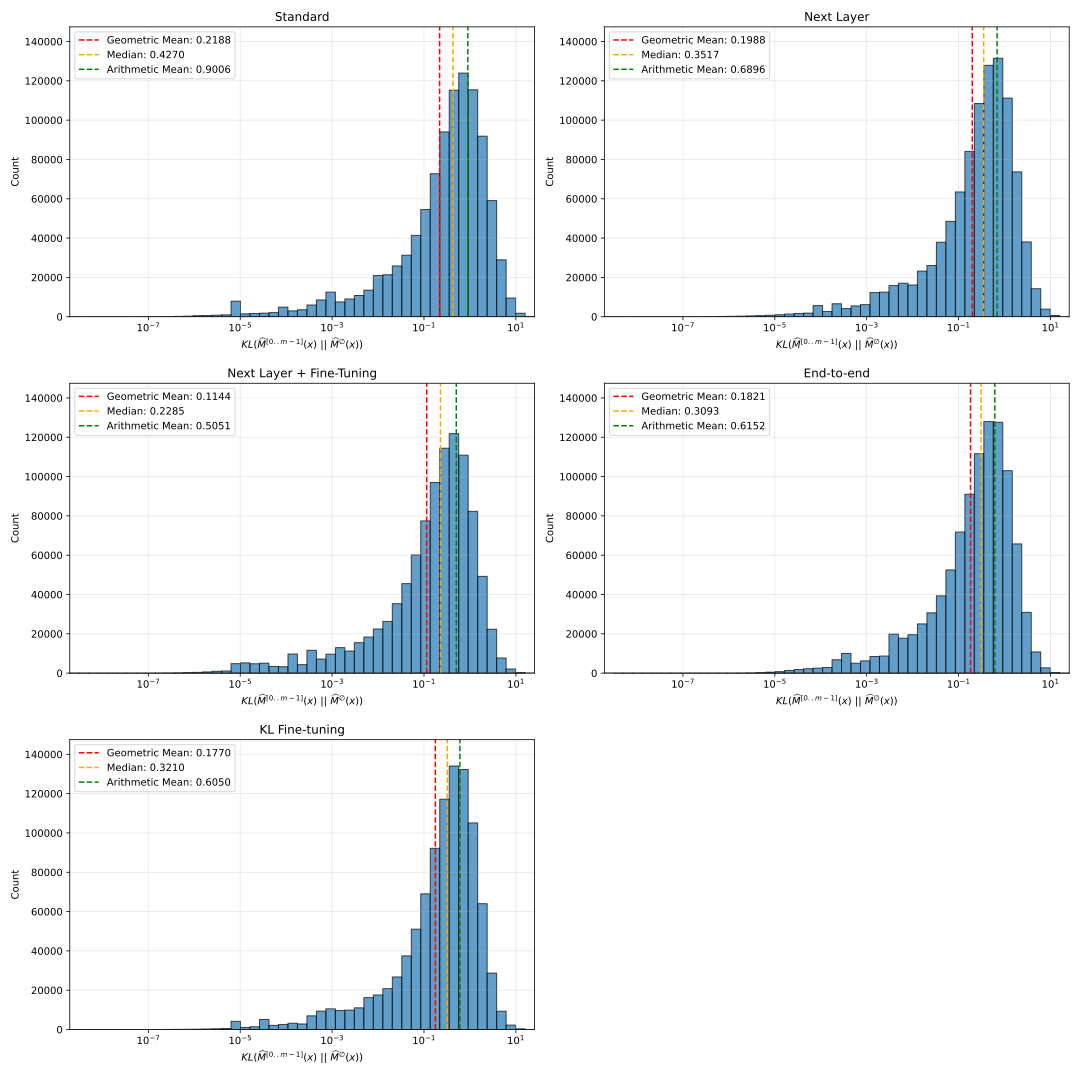

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from tiny_stories_sae.ops import current_plot_to_svg

# Plot histograms of KL divergence for each method
num_methods = len(list(replacement_evals.keys()))
ncols = 2
nrows = (num_methods + ncols - 1) // ncols  # Ceiling division

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))

# Handle case where we have only one row
if nrows == 1:
    axes = axes.reshape(1, -1)
# Handle case where we have only one method
if num_methods == 1:
    axes = axes.reshape(-1)

# Calculate global min/max for consistent bins across all methods
all_kl_values = []
for method in replacement_evals.keys():
    kl_values = replacement_evals[method]["kl"]
    all_kl_values.extend(kl_values[kl_values > 0])

global_min = np.min(all_kl_values)
global_max = np.max(all_kl_values)
log_bins = np.logspace(np.log10(global_min), np.log10(global_max), 50)

# Calculate global y-axis limits
max_frequency = 0
for method in replacement_evals.keys():
    kl_values = replacement_evals[method]["kl"]
    counts, _ = np.histogram(kl_values, bins=log_bins)
    max_frequency = max(max_frequency, np.max(counts))

for i, method in enumerate(replacement_evals.keys()):
    row = i // ncols
    col = i % ncols
    ax = axes[row, col] if nrows > 1 else axes[col]
    
    kl_values = replacement_evals[method]["kl"]

    # Create histogram with consistent bins
    ax.hist(kl_values, bins=log_bins, alpha=0.7, edgecolor="black")
    ax.set_xscale("log")
    ax.set_xlim(global_min, global_max)
    ax.set_ylim(0, max_frequency * 1.1)
    ax.set_xlabel(r"$KL(\widehat{M}^{[0..m-1]}(x)\ ||\ \widehat{M}^{\emptyset}(x))$")
    ax.set_ylabel("Count")
    ax.set_title(method.value)
    ax.grid(True, alpha=0.3)

    # Compute log-normal distribution statistics
    log_kl_values = np.log(kl_values[kl_values > 0])
    log_mean = np.mean(log_kl_values)
    log_std = np.std(log_kl_values)
    
    # Geometric mean and geometric standard deviation for log-normal distribution
    geometric_mean = np.exp(log_mean)
    geometric_std = np.exp(log_std)
    
    # Median is the same as geometric mean for log-normal
    median_kl = np.median(kl_values)
    
    # Arithmetic mean
    mean_kl = np.mean(kl_values)
    
    ax.axvline(geometric_mean, color="red", linestyle="--", label=f"Geometric Mean: {geometric_mean:.4f}")
    ax.axvline(
        median_kl, color="orange", linestyle="--", label=f"Median: {median_kl:.4f}"
    )
    ax.axvline(
        mean_kl, color="green", linestyle="--", label=f"Arithmetic Mean: {mean_kl:.4f}"
    )
    
    ax.legend()

# Hide any unused subplots
for i in range(num_methods, nrows * ncols):
    row = i // ncols
    col = i % ncols
    ax = axes[row, col] if nrows > 1 else axes[col]
    ax.set_visible(False)

plt.tight_layout()
current_plot_to_svg("validation_kl_dist")

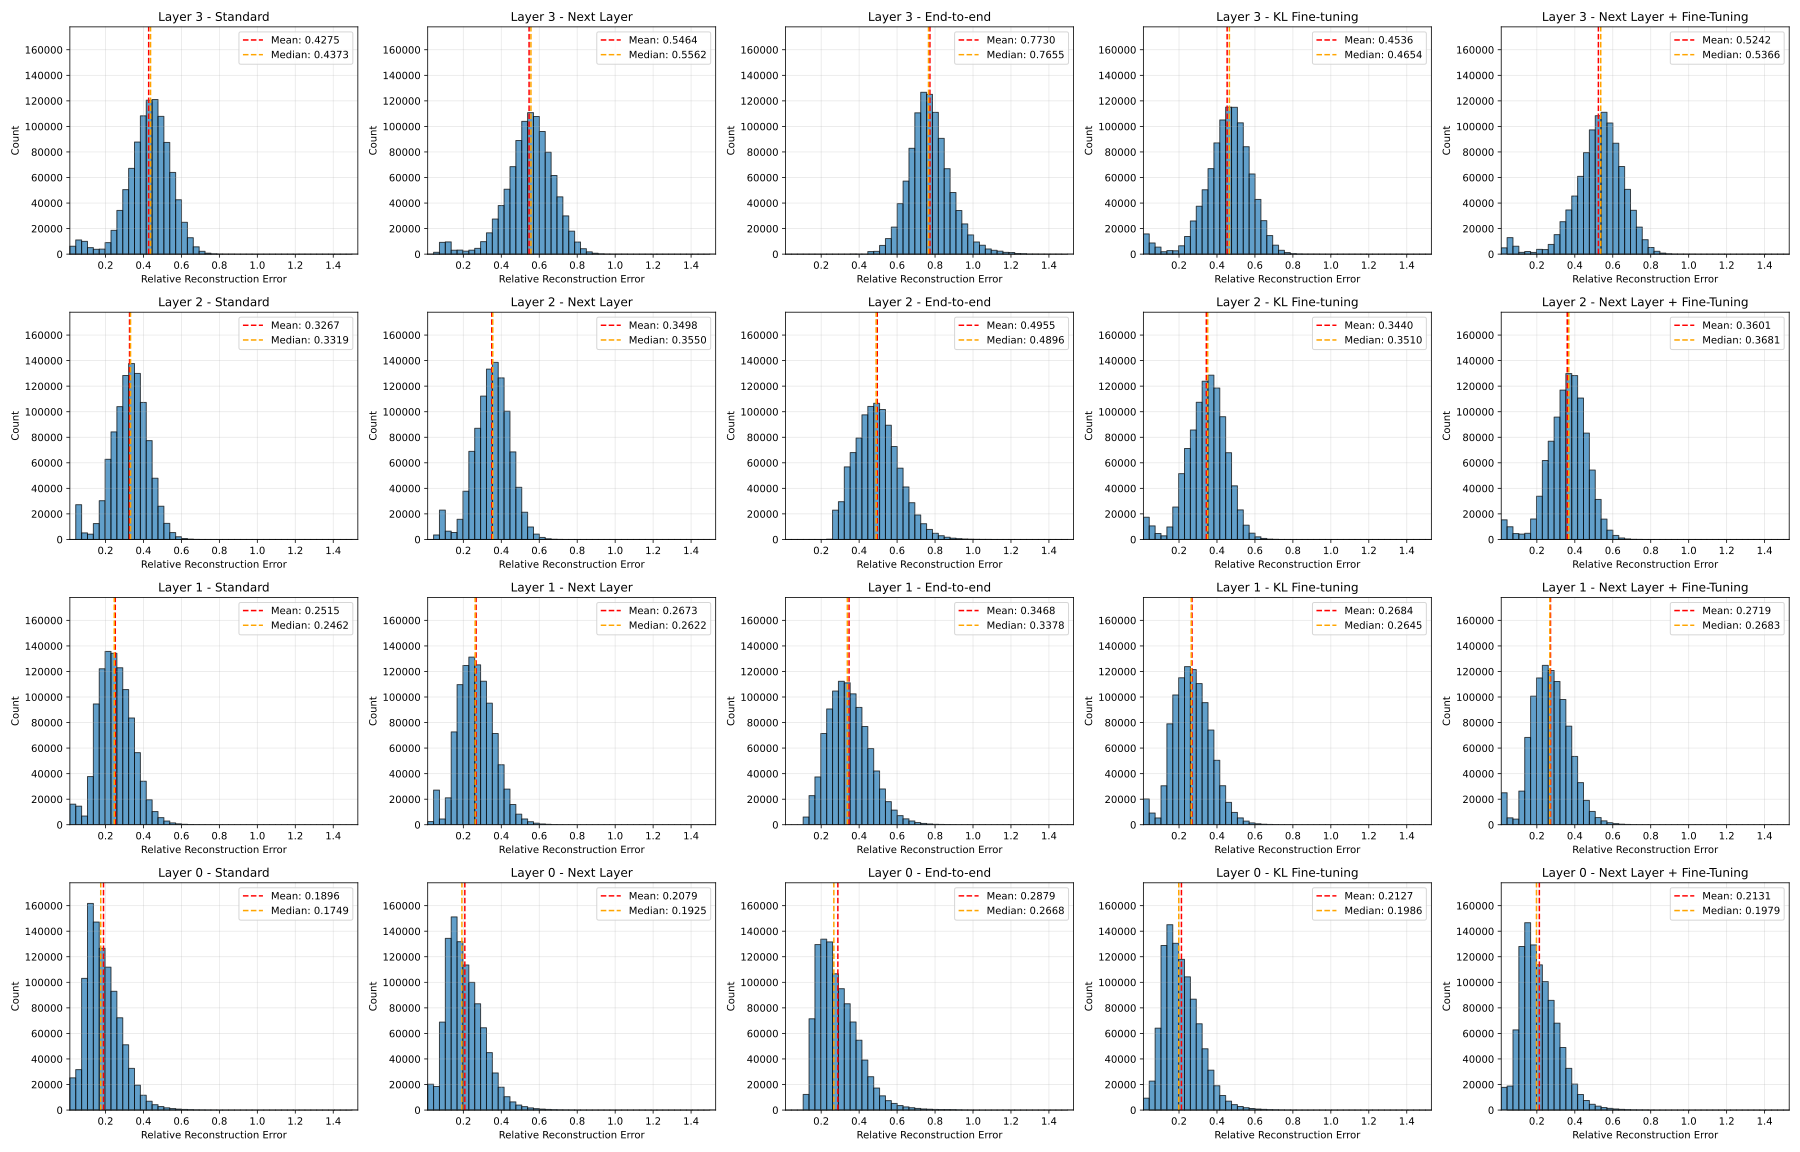

In [15]:
ncols = len(TrainingMethod)
nrows = model.config.num_layers

# Plot reconstruction error histograms
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))

# Collect all rcn values to determine global range
all_rcn_values = []
for method in TrainingMethod:
    for layer in range(model.config.num_layers):
        rcn_values = validation_evals[method][layer]["rcn"]
        all_rcn_values.extend(rcn_values)

# Create consistent bins for all histograms
global_min = min(all_rcn_values)
global_max = max(all_rcn_values)
bins = np.linspace(global_min, global_max, 50)

# Find maximum frequency for consistent y-axis scaling
max_frequency = 0
for method in TrainingMethod:
    for layer in range(model.config.num_layers):
        rcn_values = validation_evals[method][layer]["rcn"]
        counts, _ = np.histogram(rcn_values, bins=bins)
        max_frequency = max(max_frequency, max(counts))

# Plot histograms for each layer and method
for layer in range(model.config.num_layers):
    for i, method in enumerate(TrainingMethod):
        # Reverse layer order: highest layer numbers on top
        plot_row = (model.config.num_layers - 1 - layer)
        row = plot_row
        col = i
        ax = axes[row][col]
        
        rcn_values = validation_evals[method][layer]["rcn"]
        
        # Create histogram with consistent bins
        ax.hist(rcn_values, bins=bins, alpha=0.7, edgecolor="black")
        ax.set_xlim(global_min, global_max)
        ax.set_ylim(0, max_frequency * 1.1)
        ax.set_xlabel("Relative Reconstruction Error")
        ax.set_ylabel("Count")
        ax.set_title(f"Layer {layer} - {method.value}")
        ax.grid(True, alpha=0.3)
        
        # Add statistics
        mean_rcn = np.mean(rcn_values)
        median_rcn = np.median(rcn_values)
        
        ax.axvline(mean_rcn, color="red", linestyle="--", label=f"Mean: {mean_rcn:.4f}")
        ax.axvline(median_rcn, color="orange", linestyle="--", label=f"Median: {median_rcn:.4f}")
        
        ax.legend()

# Hide any unused subplots
total_plots = model.config.num_layers * len(TrainingMethod)
for i in range(total_plots, nrows * ncols):
    row = i // ncols
    col = i % ncols
    ax = axes[row][col]
    ax.set_visible(False)

plt.tight_layout()
current_plot_to_svg("validation_rcn")


In [16]:
from tiny_stories_sae.validation import generate_with_replacement
from IPython.display import HTML

# Generate completions with and without SAE replacement
prompt = "Once upon a time"
sample_generations = {}

# Generate without replacement (baseline)
print("Generating baseline completion...")
baseline_tokens = generate_with_replacement(
    model, tokenizer, prompt, saes={}, do_sample=False, stream=False
)
sample_generations["Baseline"] = tokenizer.decode(baseline_tokens[0], skip_special_tokens=True)

# # Generate with each SAE method
for method in TrainingMethod:
    print(f"Generating completion with {method.value}...")
    method_tokens = generate_with_replacement(
        model,
        tokenizer,
        prompt,
        saes=saes[method],
        do_sample=False,
        stream=False,
    )
    sample_generations[method.value] = tokenizer.decode(method_tokens[0], skip_special_tokens=True)

# Display results in HTML table
html_table = """
<table border="1" style="border-collapse: collapse; width: 100%;">
<tr style="background-color: #f2f2f2;">
<th style="padding: 10px; text-align: left;">Method</th>
<th style="padding: 10px; text-align: left;">Generated Text</th>
</tr>
"""

for method_name, text in sample_generations.items():
    html_table += f"""
<tr>
<td style="padding: 10px; vertical-align: top; font-weight: bold;">{method_name}</td>
<td style="padding: 10px; font-family: monospace; white-space: pre-wrap;">{text}</td>
</tr>
"""

html_table += "</table>"

display(HTML(html_table))


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating baseline completion...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating completion with Standard...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating completion with Next Layer...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating completion with End-to-end...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating completion with KL Fine-tuning...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating completion with Next Layer + Fine-Tuning...


Method,Generated Text
Baseline,"Once upon a time, there was a little girl named Lily. She loved to play outside in the sunshine. One day, she saw a big, red apple on the ground. She picked it up and took a bite. It was so juicy and delicious! Suddenly, she heard a loud noise. It was a big, scary dog! Lily was scared and didn't know what to do. But then, she remembered the apple she had picked earlier. She took a bite and it was even more delicious than before! Lily learned that sometimes things that look scary can be delicious. She also learned that it's important to be brave and not give up. From that day on, Lily always carried an apple with her, just in case she needed to face her fears."
Standard,"Once upon a time, there was a little girl named Lily. She loved to play outside and explore. One day, she found a big, shiny rock in the grass. She picked it up and held it in her hands. She was so happy to have it. Lily decided to take it home with her. She put it in her pocket and went to her mommy. Her mommy said, ""Lily, you have a very special rock. It is very special."" Lily was so happy to have her special rock. Later that day, Lily went to the park with her mommy. She saw a big tree and wanted to climb it. But she was scared and didn't know how to climb it. Her mommy said, ""Don't worry, Lily. We can use your special rock to help you climb the tree."" Lily was happy and started to climb. When she reached the top, she was so proud of herself. From then on, Lily knew she could do anything with her special rock. And she knew that she could do anything she wanted."
Next Layer,"Once upon a time, there was a little girl named Lily. She loved to play with her toys and explore the world around her. One day, she found a shiny silver object in her pocket. She picked it up and showed it to her mommy. ""Mommy, look what I found!"" Lily said, holding up the shiny silver object. ""Wow, that's a pretty silver,"" her mommy replied. Lily put the silver in her pocket and continued to explore the world around her. She wanted to show her mommy the shiny silver object, but she was too small to make it work. So, she decided to take it out and show it to her mommy. ""Mommy, can I keep this shiny silver thing?"" Lily asked. ""Yes, you can keep it,"" her mommy replied. Lily was so excited to have found such a special thing in her pocket. She put the silver shiny silver object back in her pocket and went back to playing with her toys. She was so proud of herself for being so brave and not too small to keep something shiny."
End-to-end,"Once upon a time, there was a little girl named Lily. She loved to play outside in the park. One day, she saw a big tree with a swing and wanted to swing on it. She asked her mommy if she could have a swing. Her mommy said yes and Lily ran to the swing set. She swung high and low, feeling the wind in her hair. She felt so happy and peaceful. After a while, Lily's mommy said it was time to go home. Lily was sad to leave but she knew she had to go. She said goodbye to the swing and went home. When she got home, her mommy gave her a big hug and said she had a surprise for her. She had a big bag of candy and a big smile on her face. Lily was so happy and grateful for her candy. She couldn't wait to eat it and show it to her friends."
KL Fine-tuning,"Once upon a time, there was a little girl named Lily. She loved to play outside in the sunshine. One day, she saw a big tree with lots of shade in the shade. She wanted to climb up the tree, but it was too high. Lily asked her mom for help. Her mom said, ""Let's build a ladder out of some wood and sticks. Then you can climb up the tree."" So, they built a ladder out of the tree and Lily climbed up. When Lily reached the top, she felt very proud of herself. She looked down at the sky and saw the sun shining. She said, ""I'm so happy to be at the top!"" Her mom smiled and said, ""Yes, it sure is. You did a great job!"""
Next Layer + Fine-Tuning,"Once upon a time, there was a l

# Save training runs

In [ ]:
# from tiny_stories_sae.ops import save_demo_run

# save_demo_run(
#     "/tmp/1e7_gold",
#     saes,
#     training_config,
#     training_results,
#     validation_evals,
#     replacement_evals,
# )


In [18]:
# from tiny_stories_sae.ops import load_demo_run

# saes, training_config, training_results, validation_evals, replacement_evals = (
#     load_demo_run(
#         "/tmp/demo_runs/tiny_stories_demo/",
#         # TODO: obviously we should have been persisting these in something like an SAEConfig class
#         (
#             D_MODEL,
#             D_SAE,
#         ),
#         dict(
#             device=TRAINING_DEVICE,
#             kind="topk",
#             topk=100,
#         ),
#     )
# )